# Gaussian Process Distribution of Relaxation Times

## In this tutorial, we will try to handle the exception that may be encountered while doing the Cholesky decomposition for $\mathbf K_{\rm im}^{\rm full}$ https://doi.org/10.1016/j.electacta.2019.135316

This tutorial is based on that `ex1_simple_ZARC.ipynb` and we will handle the exception during in the `np.linalg.cholesky(K_im_full)`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import GP_DRT
from scipy.optimize import minimize
%matplotlib inline

## 1) Define parameters of the ZARC circuit

In [2]:
# define the frequency range
N_freqs = 81
freq_vec = np.logspace(-4., 4., num=N_freqs, endpoint=True)
xi_vec = np.log(freq_vec)
tau  = 1/freq_vec

# define the frequency range used for prediction
# note: we could have used other values
freq_vec_star = np.logspace(-4., 4., num=81, endpoint=True)
xi_vec_star = np.log(freq_vec_star)

# parameters for ZARC model, the impedance and analytical DRT are calculated as the above equations
R_inf = 10
R_ct = 50
phi = 0.8
tau_0 = 1.

C = tau_0**phi/R_ct
Z_exact = R_inf+1./(1./R_ct+C*(1j*2.*pi*freq_vec)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau/tau_0))-cos((1.-phi)*pi))

# we will use a finer mesh for plotting the results
freq_vec_plot  = np.logspace(-4., 4., num=10*(N_freqs-1), endpoint=True)
tau_plot  = 1/freq_vec_plot
# for plotting only
gamma_fct_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_plot/tau_0))-cos((1.-phi)*pi))

# we will add noise to the impedance computed analytically
rng = np.random.seed(214975)
sigma_n_exp = 1.
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

## 2) Show the synthetic impedance in the Nyquist plot

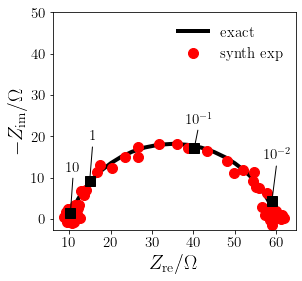

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Nyquist plot of the impedance
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color="black", label="exact")
plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=10, color="red", label="synth exp")
plt.plot(np.real(Z_exp[20:60:10]), -np.imag(Z_exp[20:60:10]), 's', markersize=10, color="black")
plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 60, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
# label the frequency points
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])-2, 10-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30])-2, 6-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$1$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40]), 10-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10$', xy=(np.real(Z_exp[50]), -np.imag(Z_exp[50])), 
             xytext=(np.real(Z_exp[50])-1, 10-np.imag(Z_exp[50])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.show()

## 3) Compute the optimal hyperparameters

In [18]:
# initialize the parameters for the minimization of the NMLL, see (31) in the manuscript
sigma_n = 1.0
sigma_f = 5.0
ell = 0.001

theta_0 = np.array([sigma_n, sigma_f, ell])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('{0:.7f}  {1:.7f}  {2:.7f}'.format(theta[0], theta[1], theta[2]))

print('sigma_n,   sigma_f,   ell')

# minimize the NMLL L(\theta) w.r.t sigma_n, sigma_f, ell using the Newton-CG method as implemented in scipy
# Here we will show one solution to handle the exception that may be raised in np.linalg.cholesky(K_im_full) 
# due to the non-positive definite K_im_full
# Once the message of "numpy.linalg.LinAlgError: Matrix is not positive definite" appears, we modify the theta_0
# to ensure that the K_im_full becomes positive definite

# the flag to denote whether the K_im_full can be successfully decomposed
# ch_flag = True
# while ch_flag:
#     try:
#         res = minimize(GP_DRT.NMLL_fct, theta_0, args=(Z_exp, xi_vec), method='Newton-CG', 
#                        jac=GP_DRT.grad_NMLL_fct,  callback=print_results, options={'disp': True})
#         ch_flag = False
#     except np.linalg.LinAlgError as err:
#         if 'positive definite' in str(err):
#             theta_0 = np.abs([sigma_n, sigma_f, ell]) + np.random.random()*np.ones((3))

res = minimize(GP_DRT.NMLL_fct, theta_0, args=(Z_exp, xi_vec), method='Newton-CG', 
               jac=GP_DRT.grad_NMLL_fct,  callback=print_results, options={'disp': True})            
# collect the optimized parameters
sigma_n, sigma_f, ell = res.x

sigma_n,   sigma_f,   ell
1.0000290  5.0000028  0.0079106
1.0000582  5.0000205  0.0135268
1.0001011  5.0000654  0.0218110
1.0001540  5.0001736  0.0342186
1.0001779  5.0004275  0.0527574
1.0000006  5.0010074  0.0802152
0.9989934  5.0022977  0.1203504
0.9950320  5.0050874  0.1780736
0.9810932  5.0109940  0.2604866
0.9323377  5.0238470  0.3836633
0.8036473  5.0473572  0.5451553
0.8278384  5.0853525  0.7852677
0.8287949  5.1293254  1.2514261
0.8303948  5.1721020  1.2189826
0.8304461  5.2594414  1.2326420
0.8305238  5.3960799  1.2534148
0.8305327  5.4070244  1.2546809
0.8305262  5.4070989  1.2546864
0.8305267  5.4070910  1.2546867
Optimization terminated successfully.
         Current function value: 53.657989
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 87
         Hessian evaluations: 0


## 4) Core of the GP-DRT

### 4a) Compute matrices

In [13]:
K = GP_DRT.matrix_K(xi_vec, xi_vec, sigma_f, ell)
L_im_K = GP_DRT.matrix_L_im_K(xi_vec, xi_vec, sigma_f, ell)
L2_im_K = GP_DRT.matrix_L2_im_K(xi_vec, xi_vec, sigma_f, ell)
Sigma = (sigma_n**2)*np.eye(N_freqs)

### 4b) Factorize the matrices and solve the linear equations

In [14]:
# the matrix $\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I$ whose inverse is needed
K_im_full = L2_im_K + Sigma

# check if the K_im_full is positive definite, otherwise, a nearest one would replace the K_im_full
if not GP_DRT.is_PD(K_im_full):
    K_im_full = GP_DRT.nearest_PD(K_im_full)

# Cholesky factorization, L is a lower-triangular matrix
L = np.linalg.cholesky(K_im_full)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp.imag)
alpha = np.linalg.solve(L.T, alpha)

# estimate the gamma of eq (21a)
gamma_fct_est = np.dot(L_im_K, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_im_full = np.dot(inv_L.T, inv_L)

# estimate the sigma of gamma for eq (21b)
cov_gamma_fct_est = K - np.dot(L_im_K, np.dot(inv_K_im_full, L_im_K.T))
sigma_gamma_fct_est = np.sqrt(np.diag(cov_gamma_fct_est))

### 4c) Plot the obtained DRT against the analytical DRT

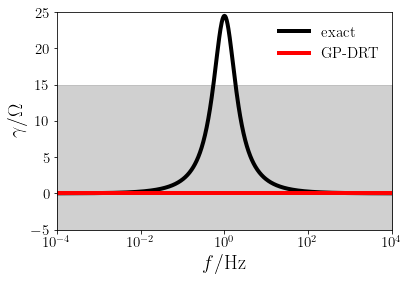

In [15]:
# plot the DRT and its confidence region
plt.semilogx(freq_vec_plot, gamma_fct_plot, linewidth=4, color="black", label="exact")
plt.semilogx(freq_vec, gamma_fct_est, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec, gamma_fct_est-3*sigma_gamma_fct_est, gamma_fct_est+3*sigma_gamma_fct_est, color="0.4", alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
plt.show()

### 4d) Predict the $\gamma$ and the imaginary part of the GP-DRT impedance

In [16]:
# initialize the imaginary part of impedance vector
Z_im_vec_star = np.empty_like(xi_vec_star)
Sigma_Z_im_vec_star = np.empty_like(xi_vec_star)

gamma_vec_star = np.empty_like(xi_vec_star)
Sigma_gamma_vec_star = np.empty_like(xi_vec_star)

# calculate the imaginary part of impedance at each $\xi$ point for the plot
for index, val in enumerate(xi_vec_star):
    xi_star = np.array([val])

    # compute matrices shown in eq (23), xi_star corresponds to a new point
    k_star = GP_DRT.matrix_K(xi_vec, xi_star, sigma_f, ell)
    L_im_k_star_up = GP_DRT.matrix_L_im_K(xi_star, xi_vec, sigma_f, ell)
    L2_im_k_star = GP_DRT.matrix_L2_im_K(xi_vec, xi_star, sigma_f, ell)
    k_star_star = GP_DRT.matrix_K(xi_star, xi_star, sigma_f, ell)
    L_im_k_star_star = GP_DRT.matrix_L_im_K(xi_star, xi_star, sigma_f, ell)
    L2_im_k_star_star = GP_DRT.matrix_L2_im_K(xi_star, xi_star, sigma_f, ell)

    # compute Z_im_star mean and standard deviation using eq (26)
    Z_im_vec_star[index] = np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_Z_im_vec_star[index] = L2_im_k_star_star-np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, L2_im_k_star))
    
    # compute gamma_star mean and standard deviation using eq (29)
    gamma_vec_star[index] = np.dot(L_im_k_star_up, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_gamma_vec_star[index] = k_star_star-np.dot(L_im_k_star_up, np.dot(inv_K_im_full, L_im_k_star_up.T))

### 4e) Plot the imaginary part of the GP-DRT impedance together with the exact one and the synthetic experiment

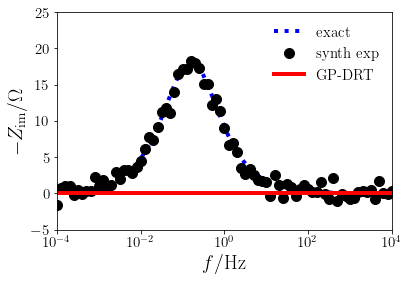

In [17]:
plt.semilogx(freq_vec_star, -np.imag(Z_exact), ":", linewidth=4, color="blue", label="exact")
plt.semilogx(freq_vec, -Z_exp.imag, "o", markersize=10, color="black", label="synth exp")
plt.semilogx(freq_vec_star, -Z_im_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec_star, -Z_im_vec_star-3*np.sqrt(abs(Sigma_Z_im_vec_star)), -Z_im_vec_star+3*np.sqrt(abs(Sigma_Z_im_vec_star)), alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()